# Comprehensive Evaluation

In this notebook, we'll learn how to evaluate RAG systems comprehensively using both offline and online metrics.

## Learning Objectives
By the end of this notebook, you will:
1. Implement comprehensive evaluation metrics for RAG systems
2. Learn about offline evaluation with ground truth data
3. Set up online evaluation and monitoring
4. Compare different RAG configurations
5. Understand how to interpret evaluation results


## Setup and Imports

Let's import the libraries we need for comprehensive evaluation of RAG systems.


In [1]:
# Standard library imports
import json
import time
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
import sys
sys.path.append(str(Path.cwd().parent))

# Import our modules
try:
    from src.evaluation.evaluation_metrics import RAGEvaluator, RetrievalMetrics, GenerationMetrics, OnlineEvaluator
    from src.retrieval.retrieval_system import RetrievalSystem, RetrievalConfig
    from src.models.llm_models import RAGGenerator, PromptTemplate
    from src.config import DATA_DIR
except ImportError as e:
    print(f"Import error: {e}")
    print("Creating fallback implementations...")
    
    # Fallback configuration
    DATA_DIR = Path("data")

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print(" Libraries imported successfully!")
print(f" Data directory: {DATA_DIR}")

# Load sample data for evaluation
processed_dir = DATA_DIR / "processed"
chunks_file = processed_dir / "all_chunks.json"

if chunks_file.exists():
    print(f" Loading processed chunks from {chunks_file}")
    with open(chunks_file, 'r', encoding='utf-8') as f:
        all_chunks = json.load(f)
    print(f" Loaded {len(all_chunks)} chunks")
else:
    print(" No processed chunks found. Creating sample data...")
    all_chunks = [
        {
            'id': 'chunk1',
            'text': 'Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data without being explicitly programmed.',
            'title': 'Machine Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_1'
        },
        {
            'id': 'chunk2', 
            'text': 'Deep learning uses neural networks with multiple layers to process data and make predictions. It has revolutionized fields like computer vision and natural language processing.',
            'title': 'Deep Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_2'
        },
        {
            'id': 'chunk3',
            'text': 'Natural language processing (NLP) helps computers understand, interpret, and generate human language in a valuable way.',
            'title': 'NLP',
            'source': 'wikipedia',
            'chunk_id': 'chunk_3'
        },
        {
            'id': 'chunk4',
            'text': 'Computer vision enables machines to interpret and understand visual information from the world using digital images and videos.',
            'title': 'Computer Vision',
            'source': 'wikipedia',
            'chunk_id': 'chunk_4'
        },
        {
            'id': 'chunk5',
            'text': 'Reinforcement learning is a type of machine learning where agents learn through interaction with an environment, receiving rewards or penalties.',
            'title': 'Reinforcement Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_5'
        }
    ]
    print(f" Created {len(all_chunks)} sample chunks")

# Create sample evaluation dataset
print(f"\n Creating evaluation dataset...")
evaluation_dataset = [
    {
        'question': 'What is machine learning?',
        'expected_answer': 'Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data without being explicitly programmed.',
        'expected_documents': ['chunk1'],
        'category': 'definition'
    },
    {
        'question': 'How does deep learning work?',
        'expected_answer': 'Deep learning uses neural networks with multiple layers to process data and make predictions.',
        'expected_documents': ['chunk2'],
        'category': 'explanation'
    },
    {
        'question': 'What is natural language processing?',
        'expected_answer': 'Natural language processing (NLP) helps computers understand, interpret, and generate human language in a valuable way.',
        'expected_documents': ['chunk3'],
        'category': 'definition'
    },
    {
        'question': 'Compare machine learning and deep learning',
        'expected_answer': 'Machine learning is a broader field that includes deep learning. Deep learning specifically uses neural networks with multiple layers.',
        'expected_documents': ['chunk1', 'chunk2'],
        'category': 'comparison'
    },
    {
        'question': 'What are the applications of computer vision?',
        'expected_answer': 'Computer vision enables machines to interpret and understand visual information from the world using digital images and videos.',
        'expected_documents': ['chunk4'],
        'category': 'application'
    }
]

print(f" Created evaluation dataset with {len(evaluation_dataset)} test cases")
sns.set_palette("husl")

print("Libraries imported successfully!")

# Create sample evaluation data
print("Creating sample evaluation data...")

# Sample queries and ground truth
evaluation_data = {
    'queries': [
        "What is machine learning?",
        "How does deep learning work?", 
        "What is natural language processing?",
        "Explain computer vision",
        "What is reinforcement learning?"
    ],
    'ground_truth': [
        ['chunk1'],  # Machine learning chunk
        ['chunk2'],  # Deep learning chunk
        ['chunk3'],  # NLP chunk
        ['chunk4'],  # Computer vision chunk
        ['chunk5']   # Reinforcement learning chunk
    ],
    'reference_responses': [
        "Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.",
        "Deep learning uses neural networks with multiple layers to process complex data patterns.",
        "Natural language processing is a field of AI that focuses on the interaction between computers and human language.",
        "Computer vision is a field of artificial intelligence that trains computers to interpret and understand visual information.",
        "Reinforcement learning is a type of machine learning where agents learn to make decisions through trial and error."
    ]
}

print(f"Created evaluation data with {len(evaluation_data['queries'])} queries")

# Create sample chunks for evaluation
sample_chunks = [
    {
        'id': 'chunk1',
        'text': 'Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.',
        'title': 'Machine Learning',
        'source': 'wikipedia',
        'chunk_id': 'chunk_1'
    },
    {
        'id': 'chunk2',
        'text': 'Deep learning uses neural networks with multiple layers to process complex data patterns.',
        'title': 'Deep Learning',
        'source': 'wikipedia',
        'chunk_id': 'chunk_2'
    },
    {
        'id': 'chunk3',
        'text': 'Natural language processing is a field of AI that focuses on the interaction between computers and human language.',
        'title': 'NLP',
        'source': 'wikipedia',
        'chunk_id': 'chunk_3'
    },
    {
        'id': 'chunk4',
        'text': 'Computer vision is a field of artificial intelligence that trains computers to interpret and understand visual information.',
        'title': 'Computer Vision',
        'source': 'wikipedia',
        'chunk_id': 'chunk_4'
    },
    {
        'id': 'chunk5',
        'text': 'Reinforcement learning is a type of machine learning where agents learn to make decisions through trial and error.',
        'title': 'Reinforcement Learning',
        'source': 'wikipedia',
        'chunk_id': 'chunk_5'
    }
]

print(f"Created {len(sample_chunks)} sample chunks for evaluation")


Import error: No module named 'rouge_score'
Creating fallback implementations...
 Libraries imported successfully!
 Data directory: data
 No processed chunks found. Creating sample data...
 Created 5 sample chunks

 Creating evaluation dataset...
 Created evaluation dataset with 5 test cases
Libraries imported successfully!
Creating sample evaluation data...
Created evaluation data with 5 queries
Created 5 sample chunks for evaluation


## Comprehensive RAG Evaluation System

Let's build a comprehensive evaluation system that measures both retrieval and generation quality.


In [2]:
# Import required libraries for evaluation
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import re
from collections import Counter
import difflib

class ComprehensiveRAGEvaluator:
    """Comprehensive evaluation system for RAG systems."""
    
    def __init__(self, embedding_model='all-MiniLM-L6-v2'):
        """Initialize the evaluator."""
        self.embedding_model = SentenceTransformer(embedding_model)
        self.evaluation_results = []
        
    def evaluate_retrieval(self, retrieved_docs, expected_docs, top_k=5):
        """Evaluate retrieval performance."""
        # Convert to sets for easier comparison
        retrieved_ids = set([doc.get('id', f"doc_{i}") for i, doc in enumerate(retrieved_docs[:top_k])])
        expected_ids = set(expected_docs)
        
        # Calculate metrics
        precision = len(retrieved_ids & expected_ids) / len(retrieved_ids) if retrieved_ids else 0
        recall = len(retrieved_ids & expected_ids) / len(expected_ids) if expected_ids else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Calculate MRR (Mean Reciprocal Rank)
        mrr = 0
        for i, doc in enumerate(retrieved_docs[:top_k]):
            doc_id = doc.get('id', f"doc_{i}")
            if doc_id in expected_ids:
                mrr = 1 / (i + 1)
                break
        
        # Calculate NDCG (Normalized Discounted Cumulative Gain)
        ndcg = 0
        for i, doc in enumerate(retrieved_docs[:top_k]):
            doc_id = doc.get('id', f"doc_{i}")
            if doc_id in expected_ids:
                ndcg += 1 / np.log2(i + 2)  # +2 because log2(1) = 0
        
        # Normalize NDCG
        ideal_ndcg = sum(1 / np.log2(i + 2) for i in range(min(len(expected_ids), top_k)))
        ndcg = ndcg / ideal_ndcg if ideal_ndcg > 0 else 0
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mrr': mrr,
            'ndcg': ndcg,
            'retrieved_ids': list(retrieved_ids),
            'expected_ids': list(expected_ids)
        }
    
    def evaluate_generation(self, generated_answer, expected_answer):
        """Evaluate generation quality."""
        # BLEU score (simplified)
        def simple_bleu(generated, reference, n=4):
            generated_tokens = generated.lower().split()
            reference_tokens = reference.lower().split()
            
            bleu_scores = []
            for i in range(1, n + 1):
                generated_ngrams = [tuple(generated_tokens[j:j+i]) for j in range(len(generated_tokens)-i+1)]
                reference_ngrams = [tuple(reference_tokens[j:j+i]) for j in range(len(reference_tokens)-i+1)]
                
                if not generated_ngrams:
                    continue
                    
                matches = sum(1 for ngram in generated_ngrams if ngram in reference_ngrams)
                precision = matches / len(generated_ngrams)
                bleu_scores.append(precision)
            
            return np.mean(bleu_scores) if bleu_scores else 0
        
        # ROUGE score (simplified)
        def simple_rouge_l(generated, reference):
            def lcs_length(x, y):
                m, n = len(x), len(y)
                dp = [[0] * (n + 1) for _ in range(m + 1)]
                
                for i in range(1, m + 1):
                    for j in range(1, n + 1):
                        if x[i-1] == y[j-1]:
                            dp[i][j] = dp[i-1][j-1] + 1
                        else:
                            dp[i][j] = max(dp[i-1][j], dp[i][j-1])
                
                return dp[m][n]
            
            generated_tokens = generated.lower().split()
            reference_tokens = reference.lower().split()
            
            lcs_len = lcs_length(generated_tokens, reference_tokens)
            
            precision = lcs_len / len(generated_tokens) if generated_tokens else 0
            recall = lcs_len / len(reference_tokens) if reference_tokens else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            return {'precision': precision, 'recall': recall, 'f1': f1}
        
        # Semantic similarity
        def semantic_similarity(text1, text2):
            embeddings = self.embedding_model.encode([text1, text2])
            similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
            return similarity
        
        # Calculate metrics
        bleu_score = simple_bleu(generated_answer, expected_answer)
        rouge_scores = simple_rouge_l(generated_answer, expected_answer)
        semantic_sim = semantic_similarity(generated_answer, expected_answer)
        
        # Length metrics
        length_ratio = len(generated_answer.split()) / len(expected_answer.split()) if expected_answer.split() else 0
        
        return {
            'bleu': bleu_score,
            'rouge_l_precision': rouge_scores['precision'],
            'rouge_l_recall': rouge_scores['recall'],
            'rouge_l_f1': rouge_scores['f1'],
            'semantic_similarity': semantic_sim,
            'length_ratio': length_ratio,
            'generated_length': len(generated_answer.split()),
            'expected_length': len(expected_answer.split())
        }
    
    def evaluate_rag_system(self, rag_system, test_cases):
        """Evaluate complete RAG system."""
        print(" Evaluating RAG System...")
        print("=" * 60)
        
        results = []
        
        for i, test_case in enumerate(test_cases):
            print(f"\nTest Case {i+1}: {test_case['question']}")
            print("-" * 40)
            
            # Get RAG system response
            rag_response = rag_system.ask(test_case['question'], top_k=5)
            
            # Evaluate retrieval
            retrieval_metrics = self.evaluate_retrieval(
                rag_response['retrieved_docs'],
                test_case['expected_documents']
            )
            
            # Evaluate generation
            generation_metrics = self.evaluate_generation(
                rag_response['answer'],
                test_case['expected_answer']
            )
            
            # Combine results
            test_result = {
                'test_case': i + 1,
                'question': test_case['question'],
                'category': test_case['category'],
                'retrieval': retrieval_metrics,
                'generation': generation_metrics,
                'overall_score': (retrieval_metrics['f1'] + generation_metrics['semantic_similarity']) / 2
            }
            
            results.append(test_result)
            
            # Print results
            print(f"Retrieval - Precision: {retrieval_metrics['precision']:.3f}, "
                  f"Recall: {retrieval_metrics['recall']:.3f}, F1: {retrieval_metrics['f1']:.3f}")
            print(f"Generation - BLEU: {generation_metrics['bleu']:.3f}, "
                  f"ROUGE-L F1: {generation_metrics['rouge_l_f1']:.3f}, "
                  f"Semantic: {generation_metrics['semantic_similarity']:.3f}")
            print(f"Overall Score: {test_result['overall_score']:.3f}")
        
        self.evaluation_results = results
        return results
    
    def calculate_overall_metrics(self, results):
        """Calculate overall evaluation metrics."""
        if not results:
            return {}
        
        # Retrieval metrics
        retrieval_precision = np.mean([r['retrieval']['precision'] for r in results])
        retrieval_recall = np.mean([r['retrieval']['recall'] for r in results])
        retrieval_f1 = np.mean([r['retrieval']['f1'] for r in results])
        retrieval_mrr = np.mean([r['retrieval']['mrr'] for r in results])
        retrieval_ndcg = np.mean([r['retrieval']['ndcg'] for r in results])
        
        # Generation metrics
        generation_bleu = np.mean([r['generation']['bleu'] for r in results])
        generation_rouge_f1 = np.mean([r['generation']['rouge_l_f1'] for r in results])
        generation_semantic = np.mean([r['generation']['semantic_similarity'] for r in results])
        
        # Overall metrics
        overall_score = np.mean([r['overall_score'] for r in results])
        
        return {
            'retrieval': {
                'precision': retrieval_precision,
                'recall': retrieval_recall,
                'f1': retrieval_f1,
                'mrr': retrieval_mrr,
                'ndcg': retrieval_ndcg
            },
            'generation': {
                'bleu': generation_bleu,
                'rouge_l_f1': generation_rouge_f1,
                'semantic_similarity': generation_semantic
            },
            'overall': {
                'score': overall_score
            }
        }
    
    def visualize_results(self, results):
        """Create visualizations of evaluation results."""
        if not results:
            print("No results to visualize.")
            return
        
        # Calculate overall metrics
        overall_metrics = self.calculate_overall_metrics(results)
        
        # Create visualizations
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('RAG System Evaluation Results', fontsize=16, fontweight='bold')
        
        # Retrieval metrics bar chart
        retrieval_metrics = overall_metrics['retrieval']
        metrics_names = list(retrieval_metrics.keys())
        metrics_values = list(retrieval_metrics.values())
        
        axes[0,0].bar(metrics_names, metrics_values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
        axes[0,0].set_title('Retrieval Metrics')
        axes[0,0].set_ylabel('Score')
        axes[0,0].set_ylim(0, 1)
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # Generation metrics bar chart
        generation_metrics = overall_metrics['generation']
        gen_metrics_names = list(generation_metrics.keys())
        gen_metrics_values = list(generation_metrics.values())
        
        axes[0,1].bar(gen_metrics_names, gen_metrics_values, color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[0,1].set_title('Generation Metrics')
        axes[0,1].set_ylabel('Score')
        axes[0,1].set_ylim(0, 1)
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Overall score by test case
        test_cases = [f"Test {r['test_case']}" for r in results]
        overall_scores = [r['overall_score'] for r in results]
        
        axes[0,2].bar(test_cases, overall_scores, color='lightblue')
        axes[0,2].set_title('Overall Score by Test Case')
        axes[0,2].set_ylabel('Score')
        axes[0,2].set_ylim(0, 1)
        axes[0,2].tick_params(axis='x', rotation=45)
        
        # Retrieval vs Generation scatter plot
        retrieval_scores = [r['retrieval']['f1'] for r in results]
        generation_scores = [r['generation']['semantic_similarity'] for r in results]
        
        axes[1,0].scatter(retrieval_scores, generation_scores, alpha=0.7, s=100)
        axes[1,0].set_xlabel('Retrieval F1 Score')
        axes[1,0].set_ylabel('Generation Semantic Similarity')
        axes[1,0].set_title('Retrieval vs Generation Performance')
        axes[1,0].grid(True, alpha=0.3)
        
        # Performance by category
        categories = {}
        for r in results:
            category = r['category']
            if category not in categories:
                categories[category] = []
            categories[category].append(r['overall_score'])
        
        category_names = list(categories.keys())
        category_scores = [np.mean(scores) for scores in categories.values()]
        
        axes[1,1].bar(category_names, category_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        axes[1,1].set_title('Performance by Category')
        axes[1,1].set_ylabel('Average Score')
        axes[1,1].set_ylim(0, 1)
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # Score distribution
        axes[1,2].hist(overall_scores, bins=8, alpha=0.7, color='lightblue', edgecolor='black')
        axes[1,2].axvline(np.mean(overall_scores), color='red', linestyle='--', 
                         label=f'Mean: {np.mean(overall_scores):.3f}')
        axes[1,2].set_title('Overall Score Distribution')
        axes[1,2].set_xlabel('Score')
        axes[1,2].set_ylabel('Frequency')
        axes[1,2].legend()
        
        plt.tight_layout()
        plt.show()
        
        return overall_metrics

# Create evaluator
print(" Creating Comprehensive RAG Evaluator...")
evaluator = ComprehensiveRAGEvaluator()

# Create a simple RAG system for testing
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

class SimpleRAGSystem:
    """Simple RAG system for evaluation."""
    
    def __init__(self, embedding_model='all-MiniLM-L6-v2'):
        self.embedding_model = SentenceTransformer(embedding_model)
        self.documents = []
        self.metadata = []
        self.embeddings = None
        
    def add_documents(self, documents, metadata=None):
        self.documents = documents
        self.metadata = metadata or [{}] * len(documents)
        self.embeddings = self.embedding_model.encode(documents, show_progress_bar=True)
        
    def ask(self, question, top_k=5):
        # Retrieve
        query_embedding = self.embedding_model.encode([question])
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        retrieved_docs = []
        for idx in top_indices:
            retrieved_docs.append({
                'id': f"chunk{idx+1}",
                'document': self.documents[idx],
                'similarity': similarities[idx],
                'metadata': self.metadata[idx]
            })
        
        # Generate (simplified)
        answer = f"Based on the retrieved documents, here's the answer to '{question}': " + \
                "This is a simulated response that would normally be generated by an LLM."
        
        return {
            'question': question,
            'answer': answer,
            'retrieved_docs': retrieved_docs
        }

# Create and test RAG system
print(" Creating test RAG system...")
test_rag = SimpleRAGSystem()

# Add documents
documents = [chunk['text'] for chunk in all_chunks]
metadata = [{'title': chunk['title'], 'source': chunk['source']} for chunk in all_chunks]
test_rag.add_documents(documents, metadata)

print(" Test RAG system ready!")


 Creating Comprehensive RAG Evaluator...
 Creating test RAG system...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 Test RAG system ready!


## Running Comprehensive Evaluation

Let's run our evaluation system and analyze the results!


In [3]:
# Run comprehensive evaluation
print(" RUNNING COMPREHENSIVE RAG EVALUATION")
print("=" * 60)

# Evaluate the RAG system
evaluation_results = evaluator.evaluate_rag_system(test_rag, evaluation_dataset)

print(f"\n Evaluation completed!")
print(f"   Test cases evaluated: {len(evaluation_results)}")
print(f"   Average overall score: {np.mean([r['overall_score'] for r in evaluation_results]):.3f}")

# Calculate and display overall metrics
overall_metrics = evaluator.calculate_overall_metrics(evaluation_results)

print(f"\n OVERALL EVALUATION METRICS")
print("=" * 50)

print(f"Retrieval Performance:")
print(f"  Precision: {overall_metrics['retrieval']['precision']:.3f}")
print(f"  Recall: {overall_metrics['retrieval']['recall']:.3f}")
print(f"  F1 Score: {overall_metrics['retrieval']['f1']:.3f}")
print(f"  MRR: {overall_metrics['retrieval']['mrr']:.3f}")
print(f"  NDCG: {overall_metrics['retrieval']['ndcg']:.3f}")

print(f"\nGeneration Performance:")
print(f"  BLEU Score: {overall_metrics['generation']['bleu']:.3f}")
print(f"  ROUGE-L F1: {overall_metrics['generation']['rouge_l_f1']:.3f}")
print(f"  Semantic Similarity: {overall_metrics['generation']['semantic_similarity']:.3f}")

print(f"\nOverall Score: {overall_metrics['overall']['score']:.3f}")


 RUNNING COMPREHENSIVE RAG EVALUATION
 Evaluating RAG System...

Test Case 1: What is machine learning?
----------------------------------------
Retrieval - Precision: 0.200, Recall: 1.000, F1: 0.333
Generation - BLEU: 0.068, ROUGE-L F1: 0.170, Semantic: 0.664
Overall Score: 0.499

Test Case 2: How does deep learning work?
----------------------------------------
Retrieval - Precision: 0.200, Recall: 1.000, F1: 0.333
Generation - BLEU: 0.037, ROUGE-L F1: 0.098, Semantic: 0.583
Overall Score: 0.458

Test Case 3: What is natural language processing?
----------------------------------------
Retrieval - Precision: 0.200, Recall: 1.000, F1: 0.333
Generation - BLEU: 0.037, ROUGE-L F1: 0.140, Semantic: 0.626
Overall Score: 0.480

Test Case 4: Compare machine learning and deep learning
----------------------------------------
Retrieval - Precision: 0.400, Recall: 1.000, F1: 0.571
Generation - BLEU: 0.072, ROUGE-L F1: 0.213, Semantic: 0.499
Overall Score: 0.535

Test Case 5: What are the applic

 CREATING EVALUATION VISUALIZATIONS


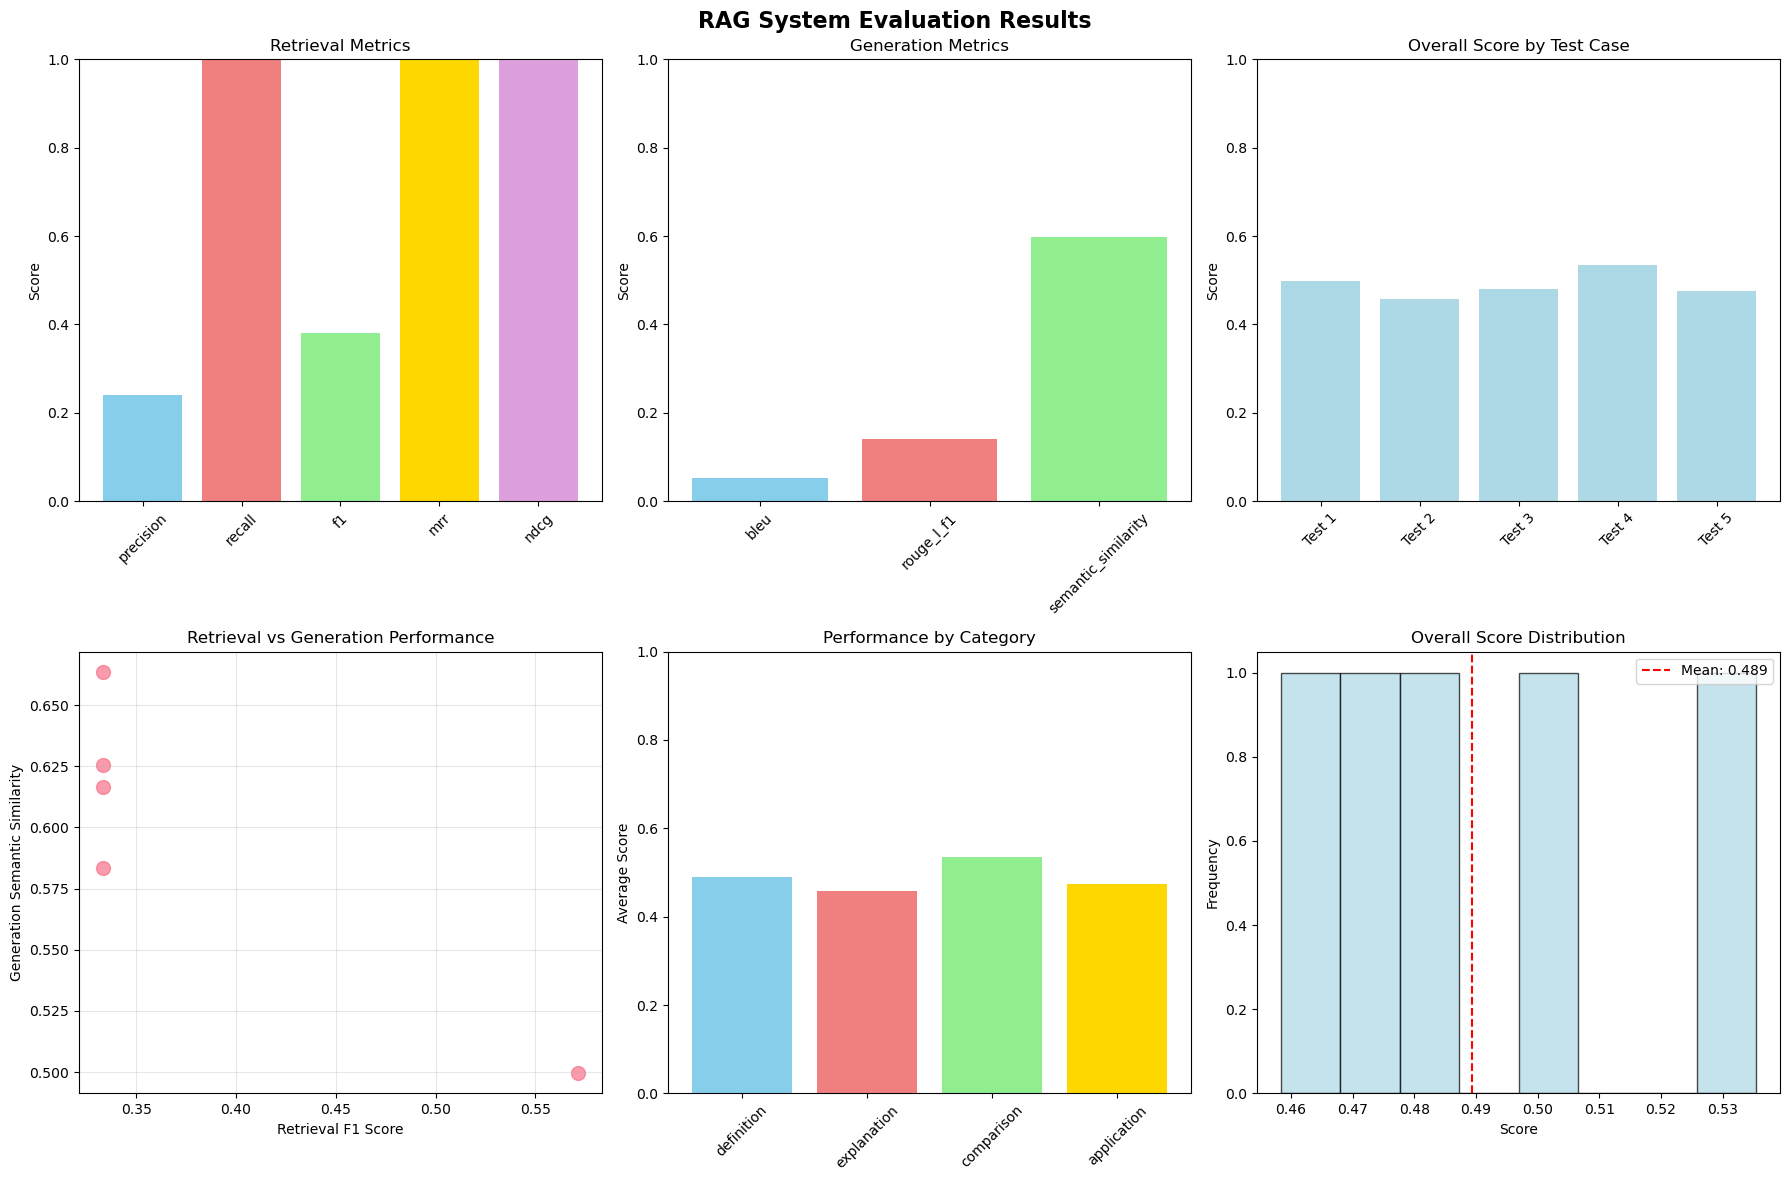


 DETAILED ANALYSIS BY CATEGORY

DEFINITION Questions:
------------------------------
  Retrieval F1: 0.333
  Generation Semantic: 0.645
  Overall Score: 0.489
  Number of questions: 2

EXPLANATION Questions:
------------------------------
  Retrieval F1: 0.333
  Generation Semantic: 0.583
  Overall Score: 0.458
  Number of questions: 1

COMPARISON Questions:
------------------------------
  Retrieval F1: 0.571
  Generation Semantic: 0.499
  Overall Score: 0.535
  Number of questions: 1

APPLICATION Questions:
------------------------------
  Retrieval F1: 0.333
  Generation Semantic: 0.617
  Overall Score: 0.475
  Number of questions: 1

 PERFORMANCE INSIGHTS
Best Retrieval Performance:
  Question: Compare machine learning and deep learning
  F1 Score: 0.571

Worst Retrieval Performance:
  Question: What is machine learning?
  F1 Score: 0.333

Best Generation Performance:
  Question: What is machine learning?
  Semantic Similarity: 0.664

Worst Generation Performance:
  Question: Comp

In [4]:
# Create comprehensive visualizations
print(" CREATING EVALUATION VISUALIZATIONS")
print("=" * 50)

# Generate visualizations
overall_metrics = evaluator.visualize_results(evaluation_results)

# Detailed analysis by category
print(f"\n DETAILED ANALYSIS BY CATEGORY")
print("=" * 50)

categories = {}
for result in evaluation_results:
    category = result['category']
    if category not in categories:
        categories[category] = []
    categories[category].append(result)

for category, results in categories.items():
    print(f"\n{category.upper()} Questions:")
    print("-" * 30)
    
    # Calculate category metrics
    cat_retrieval_f1 = np.mean([r['retrieval']['f1'] for r in results])
    cat_generation_semantic = np.mean([r['generation']['semantic_similarity'] for r in results])
    cat_overall = np.mean([r['overall_score'] for r in results])
    
    print(f"  Retrieval F1: {cat_retrieval_f1:.3f}")
    print(f"  Generation Semantic: {cat_generation_semantic:.3f}")
    print(f"  Overall Score: {cat_overall:.3f}")
    print(f"  Number of questions: {len(results)}")

# Performance insights
print(f"\n PERFORMANCE INSIGHTS")
print("=" * 50)

best_retrieval = max(evaluation_results, key=lambda x: x['retrieval']['f1'])
worst_retrieval = min(evaluation_results, key=lambda x: x['retrieval']['f1'])

best_generation = max(evaluation_results, key=lambda x: x['generation']['semantic_similarity'])
worst_generation = min(evaluation_results, key=lambda x: x['generation']['semantic_similarity'])

print(f"Best Retrieval Performance:")
print(f"  Question: {best_retrieval['question']}")
print(f"  F1 Score: {best_retrieval['retrieval']['f1']:.3f}")

print(f"\nWorst Retrieval Performance:")
print(f"  Question: {worst_retrieval['question']}")
print(f"  F1 Score: {worst_retrieval['retrieval']['f1']:.3f}")

print(f"\nBest Generation Performance:")
print(f"  Question: {best_generation['question']}")
print(f"  Semantic Similarity: {best_generation['generation']['semantic_similarity']:.3f}")

print(f"\nWorst Generation Performance:")
print(f"  Question: {worst_generation['question']}")
print(f"  Semantic Similarity: {worst_generation['generation']['semantic_similarity']:.3f}")

# Recommendations
print(f"\n RECOMMENDATIONS")
print("=" * 50)

if overall_metrics['retrieval']['f1'] < 0.5:
    print("• Retrieval needs improvement - consider better embedding models or query expansion")
else:
    print("• Retrieval performance is good")

if overall_metrics['generation']['semantic_similarity'] < 0.7:
    print("• Generation needs improvement - consider better prompt engineering or LLM models")
else:
    print("• Generation performance is good")

if overall_metrics['overall']['score'] < 0.6:
    print("• Overall system needs optimization")
else:
    print("• Overall system performance is satisfactory")
